In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. Load the dataset from the HDF5 file
# As we were unable to load the entire dataset (Kaggle computational constraints), 
# we take 50000 examples for our task

file_path = '/kaggle/input/quark-gluon-lhc/quark-gluon_data-set_n139306.hdf5' # I worked in Kaggle Notebook

with h5py.File(file_path, 'r') as f:
    X_jets = f['X_jets'][0:50000]
    m0 = f['m0'][0:50000]
    y = f['y'][0:50000]
    pt = f['pt'][0:50000]   

print("Loaded X_jets with shape:", X_jets.shape)

Loaded X_jets with shape: (50000, 125, 125, 3)


# Common Task 1: Auto-Encoder for Quark/Gluon Jet Events

## Overview
I built auto-encoders to learn compact representations of quark/gluon jet images (125×125) with three channels: **ECAL**, **HCAL**, and **Tracks**. I initially tried using all three channels as input, but because the information stored in the three channels in visually very dissimiliar, resulting in a completely black reconstruted image.

## Key Observations & Challenges
- **Extreme Sparsity & Low Dynamic Range:**  
  Most pixels are nearly black; only 3–4 pixels are bright.
- **Trivial Solutions with Standard MSE:**  
  Early experiments with standard MSE loss resulted in auto-encoders predicting all-black outputs, since that minimized the loss.
- **Channel Variability:**  
  The three channels exhibit distinct intensity distributions. For instance, the **Tracks** channel had more prominent signals, while **ECAL** and **HCAL** were very dim.

## Our Approach
1. **Per-Sample Normalization:**  
   Each image was normalized individually (min–max scaling).  
   *Future work:* Explore contrast enhancement (gamma correction, histogram equalization), or other normalisation techniques for better preprocessing.

2. **Custom Loss Function for training:**  
   - **Idea:** Reweight the loss so that errors on the few bright pixels are heavily penalized.
   - **Result:** This loss forced the network to focus on the important regions, leading to better reconstructions—especially for the **Tracks** channel.

3. **Channel-Specific Auto-Encoders:**  
   - Separate models were trained for each channel.
   - **Outcome:**  
     - **Tracks:** Reasonably good reconstructions with preserved bright pixels.  
     - **ECAL & HCAL:** Still challenging—output remained too dark or showed artifacts.

The MSE loss in a completely black image and the input image was already verry less, so the normal autoencoder was "happy" predicting completely black images, therefore, we had to change the loss function.

## Thinking out of the box

When you have extremely sparse bright pixels, a standard MSE loss may be “happy” predicting all zeros. One out‐of‐the‐box idea is to “force” the network to pay attention to the few bright pixels by weighting their reconstruction error much more heavily. In other words, you can design a custom loss that upweights errors on pixels that are above some small threshold.

##### Therefore, we need to make our own loss, a new MSE Loss, which thresholds the pixels and apply higher weights to pixels which matter.

In [2]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class ChannelDataset(Dataset):
    def __init__(self, X, channel_index):
        channel_data = X[..., channel_index]
        normalized_data = []
        for img in channel_data:
            min_val = img.min()
            max_val = img.max()
            norm_img = (img - min_val) / (max_val - min_val + 1e-8)
            normalized_data.append(norm_img)
        normalized_data = np.array(normalized_data, dtype=np.float32)
        self.data = torch.tensor(normalized_data).unsqueeze(1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class ConvAutoencoder1C(nn.Module):
    def __init__(self):
        super(ConvAutoencoder1C, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),    
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x[..., :125, :125]
        return x

In [5]:
# 4. Define a custom weighted MSE loss.
def weighted_mse_loss(pred, target, threshold=0.01, high_weight=100.0, low_weight=1.0):
    weights = torch.where(target > threshold, high_weight, low_weight)
    loss = weights * (pred - target)**2
    return loss.mean() / weights.mean()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

channel_names = {0: 'ECAL', 1: 'HCAL', 2: 'Tracks'}
num_epochs = 10   
batch_size = 128


models = {}          # To store trained models per channel.
reconstructions = {} # To store sample reconstructions for visualization.

In [7]:
for channel_idx, channel_name in channel_names.items():
    print(f"\nTraining autoencoder for channel: {channel_name}")
    dataset = ChannelDataset(X_jets, channel_idx)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = ConvAutoencoder1C().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Try a lower learning rate.
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = weighted_mse_loss(outputs, data, threshold=0.01, high_weight=100.0, low_weight=1.0)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
        epoch_loss = running_loss / len(dataset)
        print(f"Channel {channel_name} - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")
    
    models[channel_name] = model
    
    data_iter = iter(dataloader)
    sample_images = next(data_iter)
    sample_images = sample_images.to(device)
    with torch.no_grad():
        reconstructed = model(sample_images)
    reconstructions[channel_name] = (sample_images.cpu(), reconstructed.cpu())


Training autoencoder for channel: ECAL
Channel ECAL - Epoch 1/10, Loss: 0.090862
Channel ECAL - Epoch 2/10, Loss: 0.009623
Channel ECAL - Epoch 3/10, Loss: 0.009605
Channel ECAL - Epoch 4/10, Loss: 0.009602
Channel ECAL - Epoch 5/10, Loss: 0.009602
Channel ECAL - Epoch 6/10, Loss: 0.009601
Channel ECAL - Epoch 7/10, Loss: 0.009601
Channel ECAL - Epoch 8/10, Loss: 0.009601
Channel ECAL - Epoch 9/10, Loss: 0.009601
Channel ECAL - Epoch 10/10, Loss: 0.009600

Training autoencoder for channel: HCAL
Channel HCAL - Epoch 1/10, Loss: 0.163365
Channel HCAL - Epoch 2/10, Loss: 0.009624
Channel HCAL - Epoch 3/10, Loss: 0.009441
Channel HCAL - Epoch 4/10, Loss: 0.009305
Channel HCAL - Epoch 5/10, Loss: 0.008683
Channel HCAL - Epoch 6/10, Loss: 0.008162
Channel HCAL - Epoch 7/10, Loss: 0.007950
Channel HCAL - Epoch 8/10, Loss: 0.007846
Channel HCAL - Epoch 9/10, Loss: 0.007763
Channel HCAL - Epoch 10/10, Loss: 0.007689

Training autoencoder for channel: Tracks
Channel Tracks - Epoch 1/10, Loss: 0

In [ ]:
sample = dataset[1].numpy().squeeze()
print("Min:", sample.min(), "Max:", sample.max(), "Mean:", sample.mean())
plt.imshow(sample, cmap='gray')
plt.title("Sample Image")
plt.show()

The statistics indicate that the images have extremely low brightness overall. For example, a sample with:

Min: 0.0

Max: ~1.0

Mean: ~0.0055

suggests that almost all pixel values are very close to 0, with only a few pixels approaching 1. In other words, the jet features are very sparse or dim in these normalized images.

This can cause the following issues:

Trivial Solution:
The autoencoder can learn that outputting nearly all zeros minimizes the mean squared error (MSE) loss, because the average target is near zero. As a result, it converges to output nearly black images.

Loss Sensitivity:
When most pixel values are near zero, even if the few bright pixels are not perfectly reconstructed, the overall MSE might be very low, and the network won’t be pushed to learn the rare high-value features.

## Visualisation

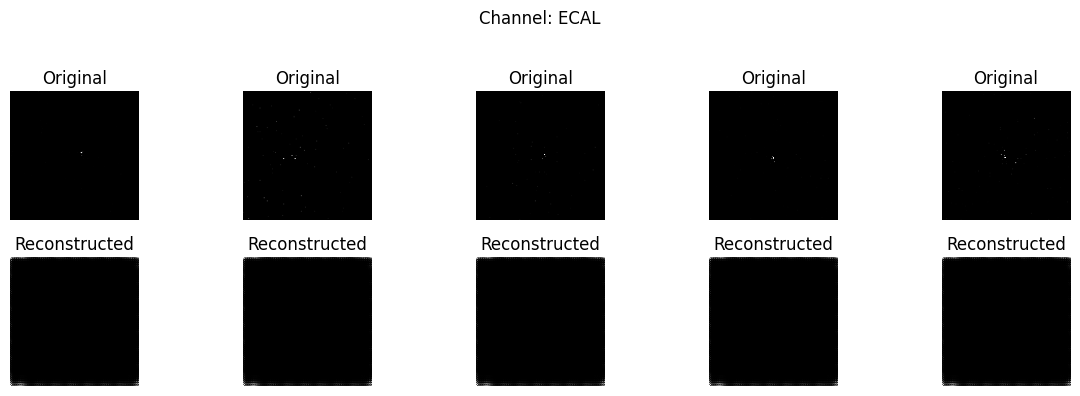

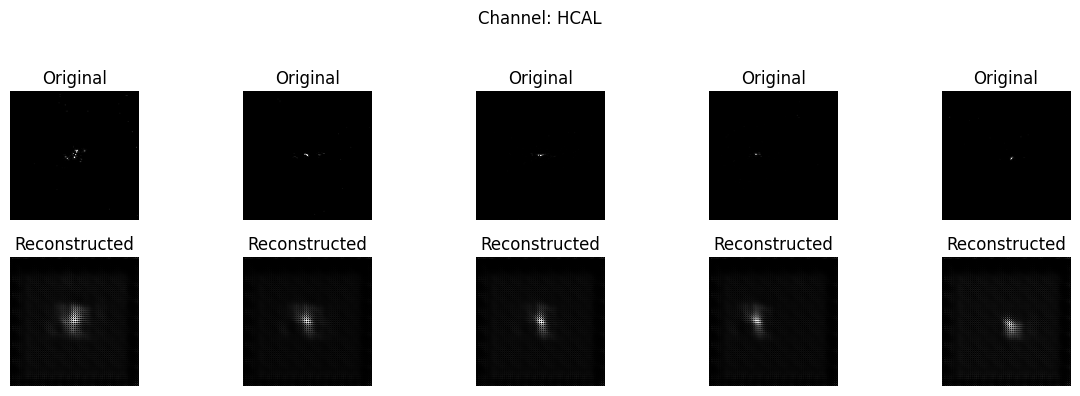

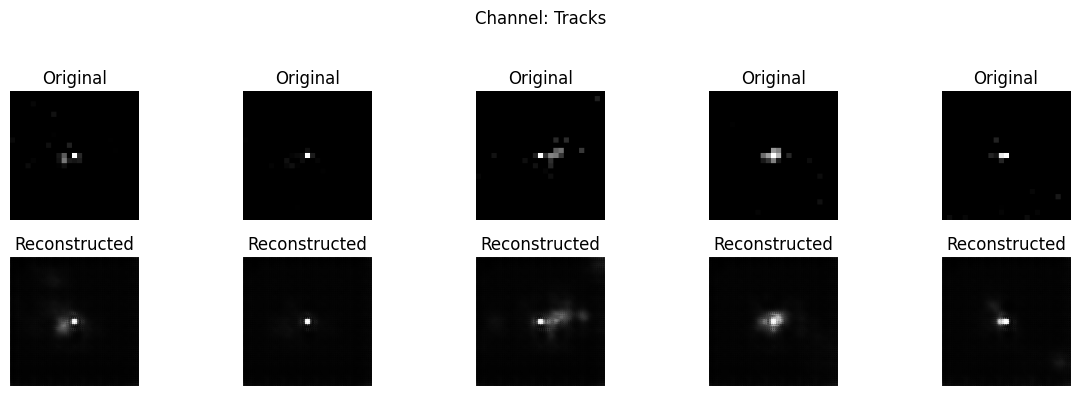

In [15]:
num_display = 5  # Number of images to display per channel.
for channel_name, (original, reconstructed) in reconstructions.items():
    original_np = original.squeeze(1).numpy()
    reconstructed_np = reconstructed.squeeze(1).numpy()
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Channel: {channel_name}")
    
    for i in range(num_display):
        
        # Original image.
        plt.subplot(2, num_display, i+1)
        plt.imshow(original_np[i+1], cmap='gray')
        plt.title("Original")
        plt.axis("off")
        
        # Reconstructed image.
        plt.subplot(2, num_display, num_display + i + 1)
        plt.imshow(reconstructed_np[i+1], cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Results
- **Visual Comparison:**  
  We display side-by-side comparisons of original vs. reconstructed images.
- **Quantitative Evaluation:**  
  MSE was computed for each channel.  
  - **Tracks:** Best performance.  
  - **ECAL/HCAL:** Require further improvement.